In [128]:

#LIBRARIES
import pandas as pd
import numpy as np

from dotenv import load_dotenv
import os

#ML LIBRARIES
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#PLOTING LIBRARIES
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style


#DATA REQUESTING LIBRARIES
import quandl
from yahoofinancials import YahooFinancials

In [153]:
# GETS THE API KEY FROM .ENV FILE
def get_key(d_key):
    
    load_dotenv('.env')
    key = os.environ.get(d_key)
    return key


# GETS DATA FROM QUANDL / DEFAULT IS BOING DATA 
def quandl_get(code="EOD/BA", start_date="1970-01-01", end_date="2019-05-30"):
    
    return quandl.get(code, start_date=start_date, end_date=end_date)


# GETS DATA FROM YAHOOFINANCIALS
def yahoo_get(ticker='AAPL', start='1970-01-01', end='2019-05-30'):
    yahoo_financials = YahooFinancials(ticker)
    dic = yahoo_financials.get_historical_price_data(start, end, 'daily')
    df = pd.DataFrame(dic[ticker]['prices'])
    return df


# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng_quandl(df, n=10):
    df['Volatility'] = (df['Adj_High'] - df['Adj_Low']) / df['Adj_Low']
    df['Change'] = (df['Adj_Close'] - df['Adj_Open']) / df['Adj_Open']
    df = df[['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']]
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    return df


# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng_yahoo(df, n=10):
    df['Volatility'] = (df['high'] - df['low']) / df['low']
    df['Change'] = (df['close'] - df['open']) / df['open']
    df = df[['close', 'Volatility', 'Change', 'volume']]
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    #Defines forecast to predict
    forecast_column = 'close'
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    df.columns = ['Adj_Close', 'Volatility', 'Change', 'Adj_Volume', 'future_price10d']
    return df    
 
    
#PLOTS CORRELATION HEATMAP AND SAVES
def plot_corr(df,size=10, title = 'Correlation'):
    style.use('ggplot')
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(corr, annot=True, cmap="Blues").set_title(title)
    fig.savefig('images/corr_heatmap.png')

    
#TRAIN LINEAR REGRESSION 
def LR_train(data):
    df = data.dropna()
    X = df.drop('future_price10d', axis=1)
    y = df['future_price10d']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    reg = LinearRegression(n_jobs=-1)
    reg.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    print('----- * SCORE * -----\n\n{}%\n\n----- * SCORE * -----'.format(round(score*100,2)))
    return score, reg


#PREDICT FUTURE VALUES
def LR_predict(df, reg ,n=10):
    X = df.drop('future_price10d', axis=1)
    X_predict = X[-n:]
    predictions = reg.predict(X_predict)
    len(df)
    prediction_column = [np.nan for _ in range(len(df)-10)]
    prediction_column.extend(predictions)
    df['Predictions'] = prediction_column
    return predictions, df


#PLOT STOCK PRICE VS TIME
def plot_stock(df, col, size=10, title='Stock'):
    style.use('ggplot')
    fig = df[[col]].plot(cmap="GnBu_r", figsize=(size,size)).set_title(title).get_figure()
    fig.savefig('images/{}.png'.format(title))
    

#PLOT PREDICTIONS
def plot_predictions(df, col, size=10, title='Stock'):
    style.use('ggplot')
    fig = df[col][-30:].plot( figsize=(size,size)).set_title(title).get_figure()
    fig.savefig('images/{}.png'.format(title))
    
#!!!! train lstm model !!!!

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


----- * SCORE * -----

98.14%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


----- * SCORE * -----

82.07%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


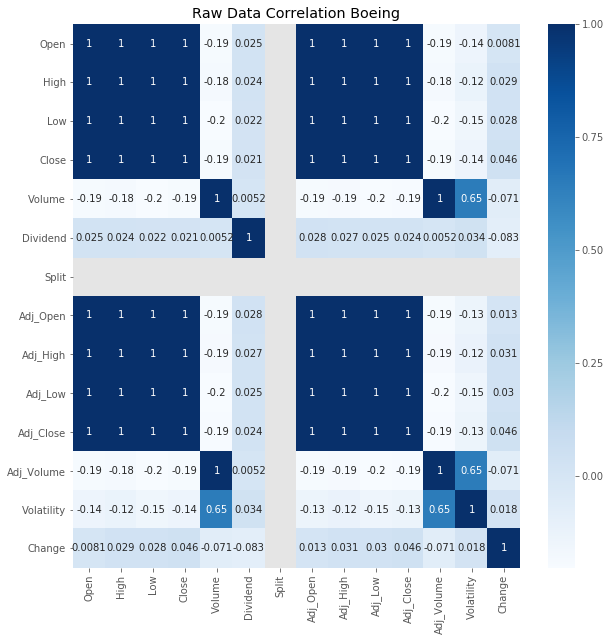

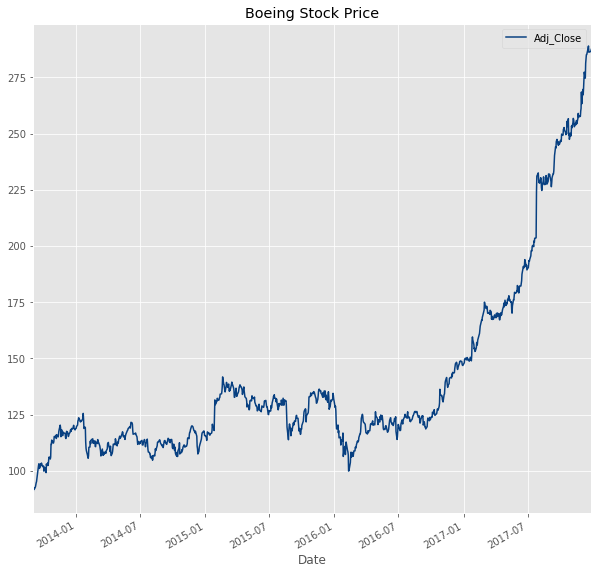

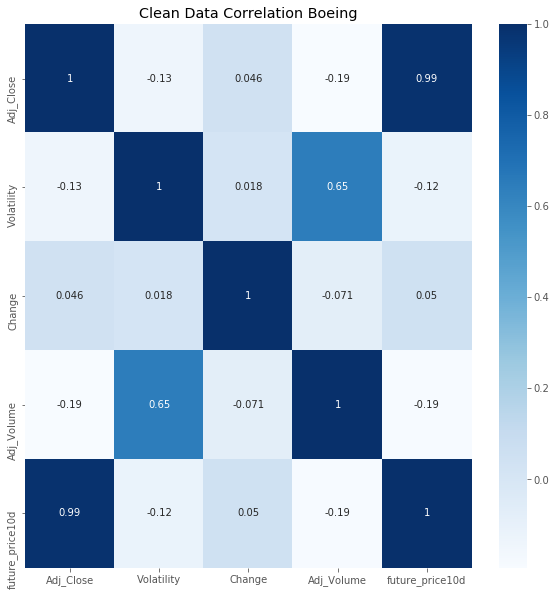

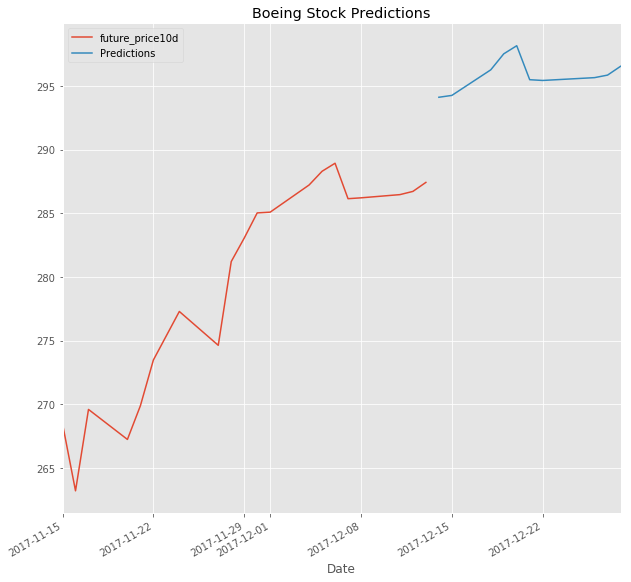

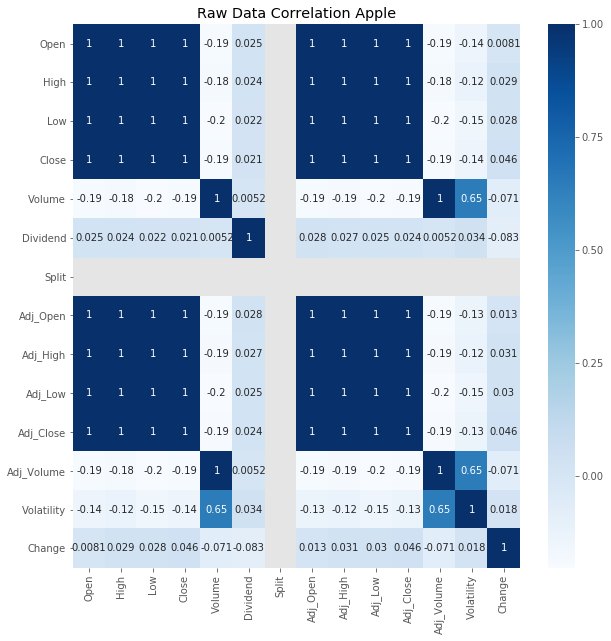

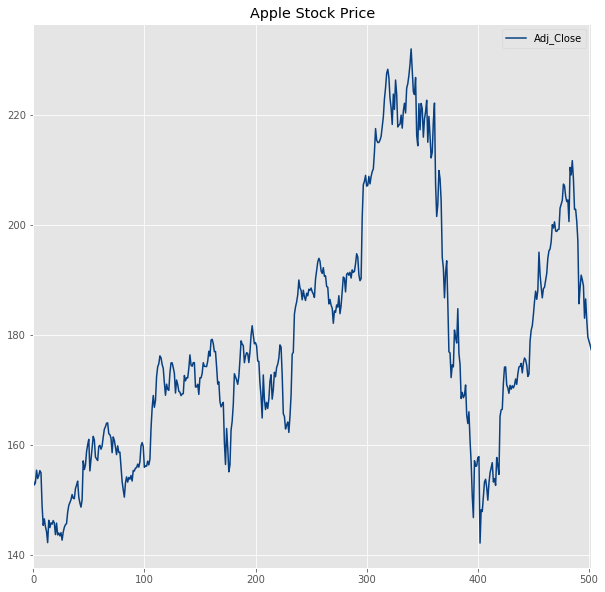

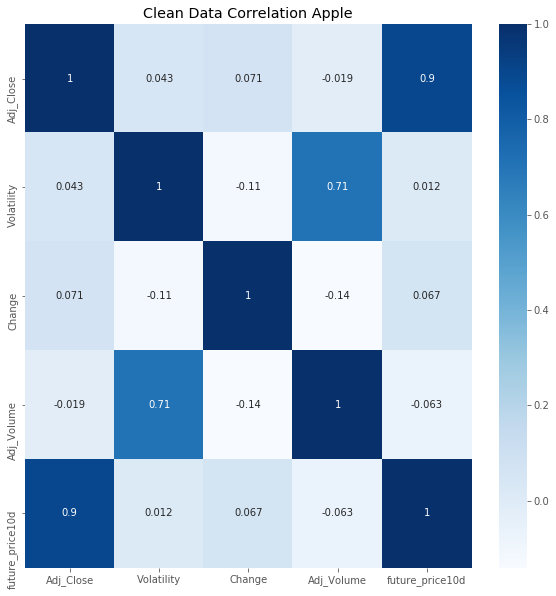

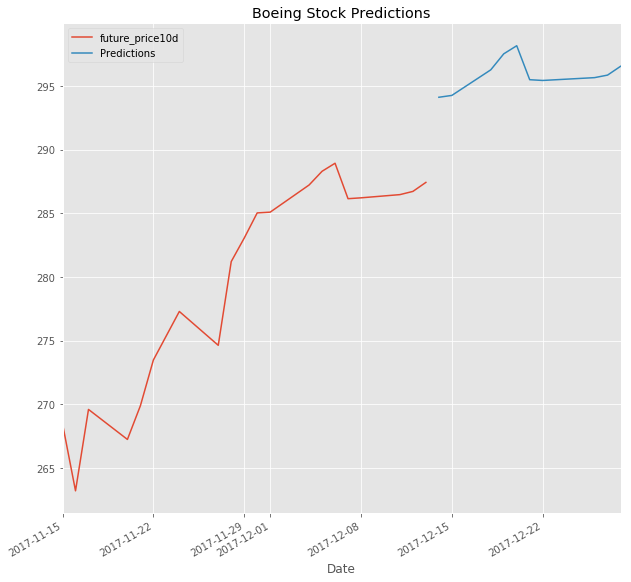

In [155]:
if __name__ == "__main__":
    
    #Define the forecast that the model is train to predict
    days_predict = 10
    
    #Request Quandl for the BOEING COMPANY historic data
    quandl_key = get_key('quandl_key')
    quandl.ApiConfig.api_key = quandl_key
    #boeing = quandl_get()
    
    #Plot data and feature correlation, clean data and featurure engineering
    plot_corr(boeing, 10, 'Raw Data Correlation Boeing')
    boeing_clean = feature_eng_quandl(boeing, days_predict)
    plot_stock(boeing_clean, 'Adj_Close',10,'Boeing Stock Price')
    plot_corr(boeing_clean, 10,'Clean Data Correlation Boeing')
    
    #Train model and predict Close Stock Prices BA
    score_boeing, reg_boeing = LR_train(boeing_clean)
    predictions_boeing, boeing_predicted = LR_predict(boeing_clean, reg_boeing, days_predict)
    plot_predictions(boeing_predicted,['future_price10d', 'Predictions'] , 10, 'Boeing Stock Predictions')
    
    #Request YahooFinance library for GOOGLE's historic data
    plot_corr(boeing, 10, 'Raw Data Correlation Apple')
    #apple = yahoo_get('AAPL', '2017-05-30', '2019-05-30')
    apple_clean = feature_eng_yahoo(apple)
    plot_stock(apple_clean, 'Adj_Close',10,'Apple Stock Price')
    plot_corr(apple_clean, 10,'Clean Data Correlation Apple')
    
    #Train model and predict Close Stock Prices AAPL
    score_apple, reg_apple = LR_train(apple_clean)
    predictions_apple, apple_predicted = LR_predict(apple_clean, reg_apple, days_predict)
    plot_predictions(boeing_predicted,['future_price10d', 'Predictions'] , 10, 'Boeing Stock Predictions')

In [152]:
apple_clean.head()



,close,Volatility,Change,volume,future_price10d
0,153.669998,0.007174,0.001630,20126900,146.589996
1,152.759995,0.011747,-0.007859,24451200,145.160004
2,153.179993,0.007292,0.000065,16404100,144.289993
3,155.449997,0.016744,0.012176,27770700,142.270004
4,153.929993,0.006451,-0.002656,25331700,146.339996
